# Melanoma Image Classification

# Importing Packages


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pydicom as dicom
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

import os
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr
import albumentations as A
import geffnet

# Importing Database

In [119]:
train = pd.read_csv('data/ISIC_2020_Training_GroundTruth_v2.csv')
train.head()

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0


In [128]:
train.columns = ['file', 'patient_id', 'lesion_id', 'gender', 'age', 'site', 'diagnosis', 'ben_mal', 'target']
train.head()

,file,patient_id,lesion_id,gender,age,site,diagnosis,ben_mal,target
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0


In [129]:
train['jpg'] = train['file'].apply(lambda x: str(x) + ".jpg")
train.head()

,file,patient_id,lesion_id,gender,age,site,diagnosis,ben_mal,target,jpg
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0,ISIC_2637011.jpg
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0,ISIC_0015719.jpg
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0,ISIC_0052212.jpg
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0,ISIC_0068279.jpg
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0,ISIC_0074268.jpg


In [132]:
train.shape

(33126, 10)

In [133]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file        33126 non-null  object 
 1   patient_id  33126 non-null  object 
 2   lesion_id   33126 non-null  object 
 3   gender      33061 non-null  object 
 4   age         33058 non-null  float64
 5   site        32599 non-null  object 
 6   diagnosis   33126 non-null  object 
 7   ben_mal     33126 non-null  object 
 8   target      33126 non-null  int64  
 9   jpg         33126 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 2.5+ MB


In [112]:
test1 = pd.read_csv('data/ISIC_2019_Training_GroundTruth.csv')
test1.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
test2 = pd.read_csv('data/ISIC_2019_Training_Metadata.csv')
test2.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [116]:
test1 = test1.rename(columns={'image':'image1'})
test2 = test2.rename(columns={'image':'image2'})
test = pd.concat([test2, test1], axis=1)
test.head()

,image2,age_approx,anatom_site_general,lesion_id,sex,image1,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,55.0,anterior torso,NaN,female,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,30.0,anterior torso,NaN,female,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,60.0,upper extremity,NaN,female,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,30.0,upper extremity,NaN,male,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,80.0,posterior torso,NaN,male,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
test = test.drop(columns=['image1'], axis=1)
test.head()

,image2,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
dummy = test[['NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']]
dummy.head()

,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
test = test.drop(columns=['NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
test.head()

,image2,age_approx,anatom_site_general,lesion_id,sex,MEL
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0


In [127]:
test.columns = ['file', 'age', 'site', 'lesion_id', 'gender', 'target']
test.head()

,file,age,site,lesion_id,gender,target
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0


In [130]:
test['jpg'] = test.file.apply(lambda x: str(x) + ".jpg")
test.head()

,file,age,site,lesion_id,gender,target,jpg
0,ISIC_0000000,55.0,anterior torso,NaN,female,0.0,ISIC_0000000.jpg
1,ISIC_0000001,30.0,anterior torso,NaN,female,0.0,ISIC_0000001.jpg
2,ISIC_0000002,60.0,upper extremity,NaN,female,1.0,ISIC_0000002.jpg
3,ISIC_0000003,30.0,upper extremity,NaN,male,0.0,ISIC_0000003.jpg
4,ISIC_0000004,80.0,posterior torso,NaN,male,1.0,ISIC_0000004.jpg


In [131]:
test.shape

(25331, 7)

In [134]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file       25331 non-null  object 
 1   age        24894 non-null  float64
 2   site       22700 non-null  object 
 3   lesion_id  23247 non-null  object 
 4   gender     24947 non-null  object 
 5   target     25331 non-null  float64
 6   jpg        25331 non-null  object 
dtypes: float64(2), object(5)
memory usage: 1.4+ MB


# Exploratory Data Analysis

## Sex Distribution

<AxesSubplot:xlabel='gender', ylabel='count'>

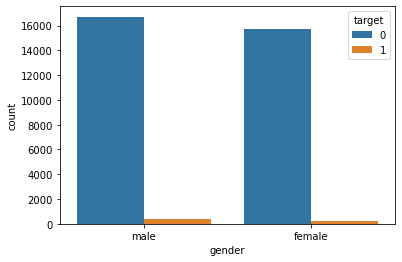

In [138]:
sns.countplot(x='gender', data=train, hue='target')

<AxesSubplot:xlabel='gender', ylabel='count'>

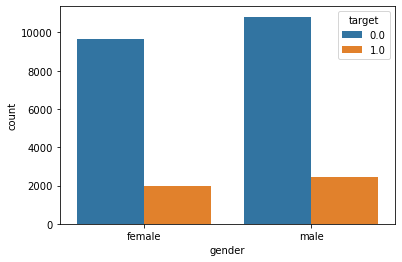

In [140]:
sns.countplot(x='gender', data=test, hue='target')

## Age Distribution

/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

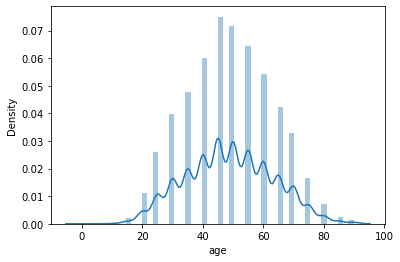

In [139]:
sns.distplot(train['age'])

/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

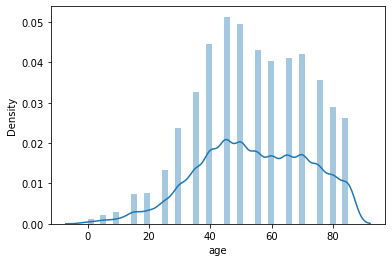

In [141]:
sns.distplot(test['age'])

## Site

In [15]:
df.site.value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: site, dtype: int64

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'head/neck'),
  Text(1, 0, 'upper extremity'),
  Text(2, 0, 'lower extremity'),
  Text(3, 0, 'torso'),
  Text(4, 0, 'palms/soles'),
  Text(5, 0, 'oral/genital')])

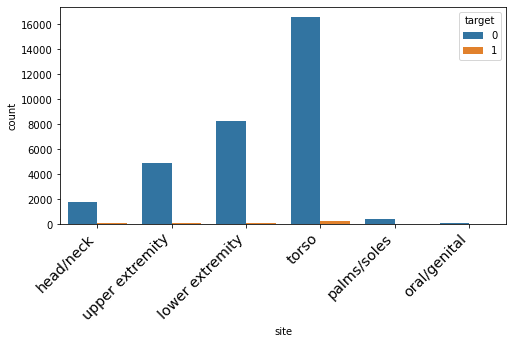

In [148]:
plt.figure(figsize=(8,4))
g = sns.countplot(x='site', data=train, hue='target')
plt.xticks(rotation=45, horizontalalignment='right', fontsize='x-large')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'anterior torso'),
  Text(1, 0, 'upper extremity'),
  Text(2, 0, 'posterior torso'),
  Text(3, 0, 'lower extremity'),
  Text(4, 0, 'lateral torso'),
  Text(5, 0, 'head/neck'),
  Text(6, 0, 'palms/soles'),
  Text(7, 0, 'oral/genital')])

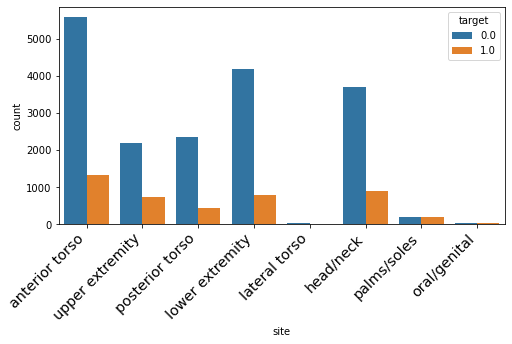

In [147]:
plt.figure(figsize=(8,4))
g = sns.countplot(x='site', data=test, hue='target')
plt.xticks(rotation=45, horizontalalignment='right', fontsize='x-large')

## Diagnosis

In [14]:
df.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

# Preprocessing

In [16]:
import os, shutil

In [ ]:
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)

In [ ]:
# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(256, 256), batch_size = 10982) 

# # get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(256, 256), batch_size = 200)

# # get all the data in the directory split/train (542 images), and reshape them
# train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         train_folder, 
#         target_size=(64, 64), batch_size=542)